# Single Ride Visualizer
Quick visual inspection of one ride. For full assessment reports run `assess_driving_safety.py`.

In [4]:
import polars as pl
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import yaml
from pathlib import Path

plt.rcParams['figure.figsize'] = (14, 4)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# ── Pick a ride ──────────────────────────────────────────────────────────────
RIDE_FILE = Path('data/2026-02-24/1ab983ef/56d1abc7.parquet')  # change as needed
# ─────────────────────────────────────────────────────────────────────────────

with open('config.yaml') as f:
    cfg = yaml.safe_load(f)
THR = cfg['assessment']['thresholds']

IMAGES_DIR = Path(cfg['output']['images_dir'])
IMAGES_DIR.mkdir(parents=True, exist_ok=True)

In [5]:
pf   = pq.read_table(RIDE_FILE)
meta = {k.decode(): v.decode() for k, v in (pf.schema.metadata or {}).items()}
FS   = int(meta.get('sampling_rate', 50))

df = pl.from_arrow(pf).with_columns(
    pl.col('timestamp').cast(pl.Datetime)
)

print(f"Ride ID   : {meta.get('ride_id')}")
print(f"Driver ID : {meta.get('driver_id')}")
print(f"Type      : {meta.get('ride_type')}")
print(f"Date      : {meta.get('date')}")
print(f"Duration  : {df['time_seconds'].max():.1f} s  ({df['time_seconds'].max()/60:.2f} min)")
print(f"Samples   : {len(df)}  @  {FS} Hz")

Ride ID   : 56d1abc7
Driver ID : 1ab983ef
Type      : aggressive
Date      : 2026-02-24
Duration  : 60.0 s  (1.00 min)
Samples   : 3000  @  50 Hz


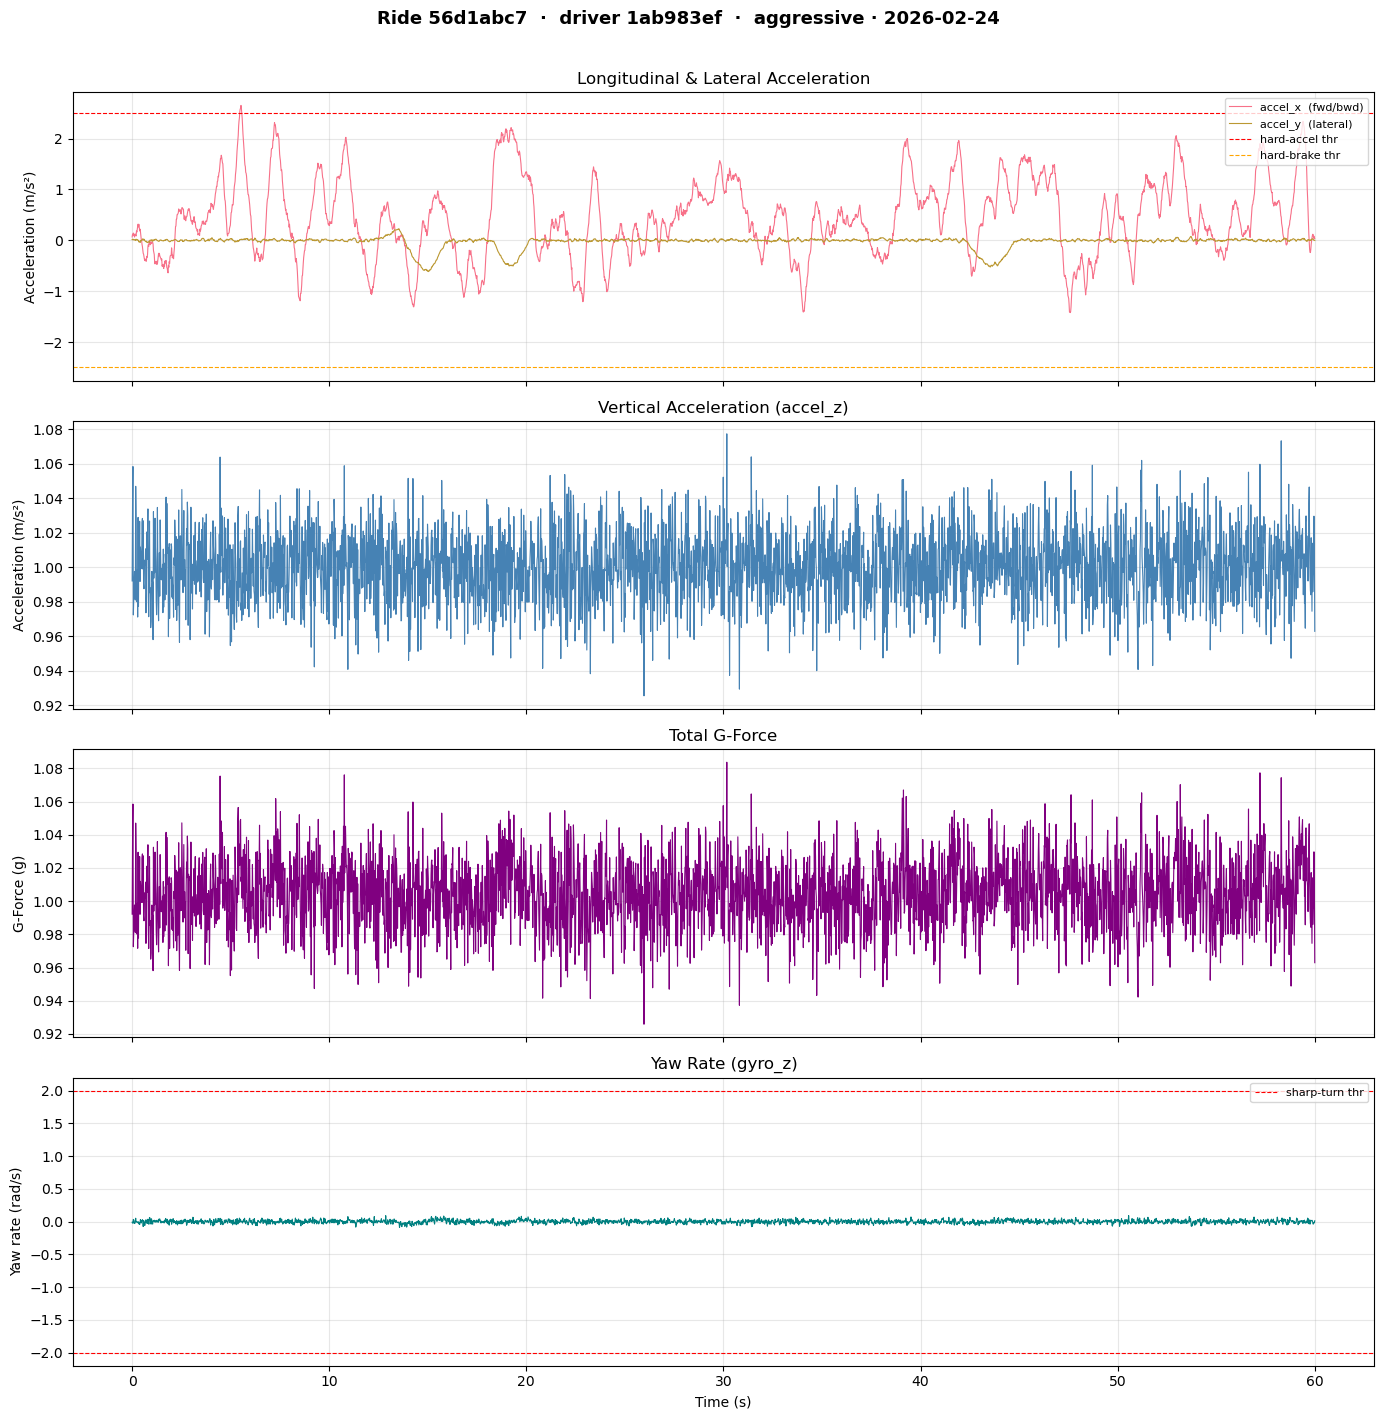

In [6]:
t = df['time_seconds'].to_numpy()

fig, axes = plt.subplots(4, 1, figsize=(14, 14), sharex=True)
fig.suptitle(
    f"Ride {meta.get('ride_id')}  ·  driver {meta.get('driver_id')}  ·  {meta.get('ride_type')} · {meta.get('date')}",
    fontsize=13, fontweight='bold', y=1.01
)

# ── Forward / Lateral acceleration ───────────────────────────────────────────
ax = axes[0]
ax.plot(t, df['accel_x'].to_numpy(), label='accel_x  (fwd/bwd)', linewidth=0.8)
ax.plot(t, df['accel_y'].to_numpy(), label='accel_y  (lateral)',  linewidth=0.8)
ax.axhline( THR['hard_accel'], color='red',   linestyle='--', linewidth=0.8, label='hard-accel thr')
ax.axhline( THR['hard_brake'], color='orange', linestyle='--', linewidth=0.8, label='hard-brake thr')
ax.set_ylabel('Acceleration (m/s²)')
ax.legend(loc='upper right', fontsize=8)
ax.set_title('Longitudinal & Lateral Acceleration')

# ── Vertical acceleration ─────────────────────────────────────────────────────
ax = axes[1]
ax.plot(t, df['accel_z'].to_numpy(), color='steelblue', linewidth=0.8)
ax.set_ylabel('Acceleration (m/s²)')
ax.set_title('Vertical Acceleration (accel_z)')

# ── Total G-force ─────────────────────────────────────────────────────────────
ax = axes[2]
ax.plot(t, df['gforce_total'].to_numpy(), color='purple', linewidth=0.8)
ax.set_ylabel('G-Force (g)')
ax.set_title('Total G-Force')

# ── Yaw rate ──────────────────────────────────────────────────────────────────
ax = axes[3]
ax.plot(t, df['gyro_z'].to_numpy(), color='teal', linewidth=0.8)
ax.axhline( THR['sharp_turn'], color='red',    linestyle='--', linewidth=0.8, label='sharp-turn thr')
ax.axhline(-THR['sharp_turn'], color='red',    linestyle='--', linewidth=0.8)
ax.set_ylabel('Yaw rate (rad/s)')
ax.set_xlabel('Time (s)')
ax.set_title('Yaw Rate (gyro_z)')
ax.legend(loc='upper right', fontsize=8)

plt.tight_layout()
out = IMAGES_DIR / f"{meta.get('ride_id', 'unknown')}_timeseries.png"
fig.savefig(out, dpi=150, bbox_inches='tight')
print(f"Saved: {out}")
plt.show()

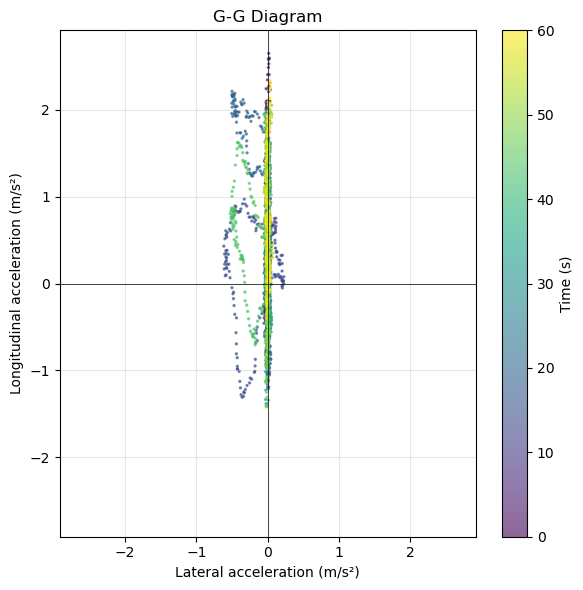

In [7]:
# G-G diagram  (lateral vs longitudinal)
fig, ax = plt.subplots(figsize=(6, 6))

sc = ax.scatter(
    df['accel_y'].to_numpy(),
    df['accel_x'].to_numpy(),
    c=t, cmap='viridis', s=2, alpha=0.6
)
plt.colorbar(sc, ax=ax, label='Time (s)')

lim = max(abs(df['accel_x'].max()), abs(df['accel_x'].min()),
          abs(df['accel_y'].max()), abs(df['accel_y'].min())) * 1.1
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.axhline(0, color='k', linewidth=0.5)
ax.axvline(0, color='k', linewidth=0.5)
ax.set_xlabel('Lateral acceleration (m/s²)')
ax.set_ylabel('Longitudinal acceleration (m/s²)')
ax.set_title('G-G Diagram')

plt.tight_layout()
out = IMAGES_DIR / f"{meta.get('ride_id', 'unknown')}_gg_diagram.png"
fig.savefig(out, dpi=150, bbox_inches='tight')
print(f"Saved: {out}")
plt.show()